# VEME NGS Module: Analyzing Single Cell RNA-seq Data

Here we will look at a downsampled version of a processed single cell RNA sequeuncing dataset that assesses host response to SARS-CoV-2.  These data were published in Nature by Melms et al. at https://www.nature.com/articles/s41586-021-03569-1.  The processed dataset that this notebook is using is found in GEO at https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE171524.

NOTE: A lot of this analysis can also be done in scanpy, demonstrated in the same link provided in the data processing tutorial.  However, since this tutorial involves some fundamental data science concepts, we want you you to do all this analysis with some of the standard python modules.

### Install proper version of numpy for sknetwork

In [1]:
%pip uninstall numpy -y
%pip install numpy==1.23.5

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-1.23.5-cp38-cp38-macosx_10_9_x86_64.whl (18.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cellxgene 1.1.2 requires numpy<=1.22,>=1.17.5, but you have numpy 1.23.5 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


### ----- MUST RESTART THE KERNEL BEFORE RUNNING -----

In [1]:
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
from distinctipy import distinctipy
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
from sknetwork.clustering import Louvain
import warnings
warnings.filterwarnings("ignore")

/Users/zwallace/opt/anaconda3/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/zwallace/opt/anaconda3/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/zwallace/opt/anaconda3/lib/python3.8/site-packages/umap/distances.py:1086: 

## 1.) Load in the processed cell by gene counts matrix

In [19]:
counts = pd.read_csv("processed_data_10_percent.csv.gz", compression = "gzip", index_col = 0)
counts.shape

(11631, 2000)

In [20]:
counts.head()

,IGKC,SFTPC,SFTPA2,IGLC2,SFTPA1,IGHG3,CEMIP,COL1A1,IGLC1,SERPINE1,...,SFTA2,AC027808.2,PFN1,FOXJ1,SLC6A4,B3GNT5,FCRL1,TNFSF15,FSTL3,RXFP1
TAGGTACCATCATCTT-1_26,-0.179842,-0.302550,-0.270006,-0.104097,-0.268914,-0.155862,0.741096,0.201830,-0.115725,1.898368,...,0.016689,0.754596,-0.089637,-0.085610,-0.150100,-0.191087,-0.238788,-0.035274,0.163645,-0.087180
GTGCTTCGTGATGTAA-1_6,-0.171866,-0.316475,-0.267945,-0.103750,-0.268676,-0.155157,-0.346043,-0.319355,-0.115247,-0.492898,...,-0.159329,-0.136208,-0.196339,-0.085418,-0.122912,-0.320130,0.086005,0.004053,-0.241957,-0.100204
AAGCGAGTCCCGAGGT-1_26,-0.172125,-0.288306,-0.269466,-0.103818,-0.269138,-0.154876,-0.439812,-0.323876,-0.115633,-0.428029,...,-0.159884,0.226238,0.238889,-0.085610,-0.154954,-0.050412,0.714853,-0.106925,-0.182437,-0.068454
CGGGACTCATCATGAC-1_2,-0.172138,-0.311949,-0.261401,-0.103819,-0.258226,-0.154678,1.220277,-0.412570,-0.115634,-0.487244,...,0.069381,-0.105492,-0.168247,-0.085610,-0.195910,-0.223893,-0.250511,-0.509968,0.248163,-0.048463
GTTGTAGCAGCTGCCA-1_3,-0.172138,-0.316067,-0.269466,-0.103819,-0.269138,-0.154678,-0.342670,-0.324338,-0.115634,-0.503068,...,-0.159884,-0.105492,-0.168256,-0.085610,-0.151069,-0.256365,-0.250511,-0.068950,-0.242164,-0.108532


###
DATA NOTE: The dataset that will be analyzed is 11,631 cells by 2000 genes.  This is a 10 percent random selection of data from the fully processed cell-by-gene single cell RNA-seq expression matrix so that we can work with the data in the VM.  This dataset also has noise background removal via CellBender (removal of technical ambient RNA counts and empty droplets), data filtering due to lack of nuclei with lack of genes, data filtering due to excess mitochondrial read counts, log normalization, scaling and data centralization, and retreival of the 2000 most variable genes.

## 2.) Reduce dimensionality with PCA and visualize with UMAP

### a. Run PCA algorithm and determine distribution of explained variance

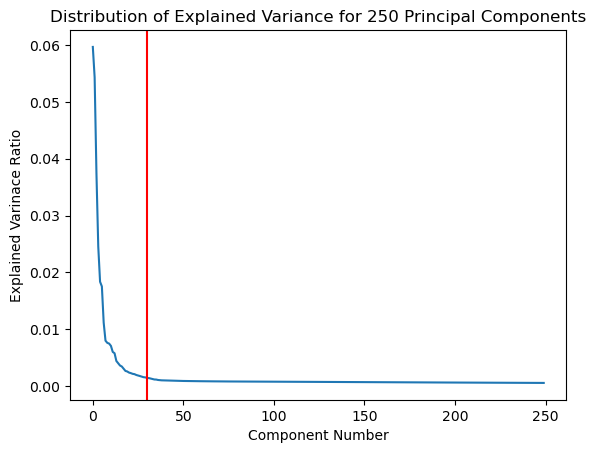

In [21]:
pca = PCA(n_components = 250, random_state = 42).fit(counts)
pca.fit(counts)

# Plot distribution of explained variance 
plt.plot(pca.explained_variance_ratio_)
plt.xlabel("Component Number")
plt.ylabel("Explained Varinace Ratio")
plt.title("Distribution of Explained Variance for 250 Principal Components")
plt.axvline(x=30, color = "r")
plt.show()

### b. Re-run PCA to reduce to 30 components

In [22]:
counts_pca = PCA(n_components = 30, random_state = 42).fit_transform(counts)
counts_pca

array([[ 18.06739032, -16.35993774,   1.12407599, ...,  -0.22524136,
         -0.38448325,  -1.67449266],
       [-11.469309  ,  -2.09471799,   1.34735596, ...,  -0.25320795,
          0.38179321,   0.63392342],
       [-13.27610976,  -3.47014021,   3.20583669, ...,  -0.27841158,
          0.04385452,  -0.1739926 ],
       ...,
       [ -9.67330155,  -1.85493419,   0.92759085, ...,  -0.06206639,
         -1.19291629,   0.94228848],
       [-12.64508723,  -2.08147084,   3.17093915, ...,  -0.06968607,
          0.25315937,   0.31118566],
       [-10.89865238,  -1.6332578 ,   1.79762031, ...,   0.59897885,
         -0.36613449,   0.41089721]])

### c. Run UMAP with default parameters

In [23]:
counts_umap = umap.UMAP(n_components = 2).fit_transform(counts_pca)

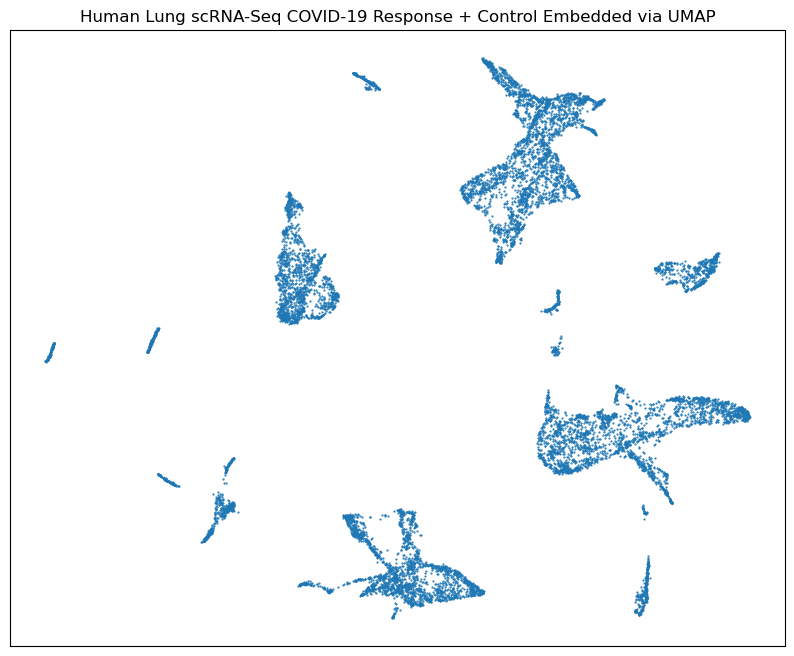

In [24]:
fig, ax = plt.subplots(1, figsize = (10,8))
plt.scatter(*counts_umap.T, s = 0.3, alpha = 1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title("Human Lung scRNA-Seq COVID-19 Response + Control Embedded via UMAP")
plt.show()

### d. Exericses: Run UMAP with alternative parameters

Go to https://umap-learn.readthedocs.io/en/latest/parameters.html and read about the paramaters. Create different UMAP embeddings with these parameter options and see how it changes the plots.  But keep the n_components at 2.

Summary of UMAP Parameters:

1.) n_neighbors - UMAP learns a manifold on a k-neighbors graph constructed from the data; n_neighbors restricts the size of this graph and determines whether manifold learning focuses more on local structure or global structure.  Increasing this parameter will cause data points to be less compact together so more separation might be seen in the UMAP visualization. Default is 15.

2.) min_dist - Minimum distance points are allowed to be in the low dimensional representation.  Decreasing this parameter will lead to clumpier embeddings and so data points will be more compact in the UMAP visualization.  Default is 0.1.

3.) n_components - Number of components to reduce to.  Only increase if interested in dimensionality reduction and not visualization (so no more than 3 components for a 3D visualization). UMAP is a non-linear dimensionality reduction technique (PCA is a linear dimensionality reduction technique), however UMAP is not typically used for dimensionality reduction in practice, usually just visualization.

4.) metric - The distance metric used for computing the min_dist.  Different data are more appropriate for different metrics, such as hamming or jaccard being better for binary data (all 0's and 1's). The default is Euclidean distance metric, the most generalize metric.

In [8]:
# UMAP embedding with alternate parameters here:



In [9]:
# Code to visualize the UMAP here:



## 3.) Clustering: Compute the K-neighbors graph and cluster the graph with Louvain

### a. Compute the K-neighbors graph

In [10]:
counts_neighbors = kneighbors_graph(X = counts_pca, n_neighbors = 50, include_self = True, n_jobs = -1)

### b. Cluster with the louvain algorithm

In [11]:
louvain = Louvain(resolution = 0.8, random_state = 42)
labels = louvain.fit_predict(counts_neighbors)
labels = np.asarray(labels)
print("Number of clusters identified by Louvain:", len(np.unique(labels)))

Number of clusters identified by Louvain: 19


### c. Exercises: Run K-neighbors graph and louvain with alternate parameters

Change the n_nieghbors parameter of kneighbors_graph and then cluster with louvain using different resolution parameters, see how it changes the number of clusters.  NOTE: Don't increase the n_neighbors parameter too high, it might increase complexity of clustering a lot. 

Question: Do the number of clusters increase or decrease with an increase of the resolution parameter?

In [12]:
# Kneighbors graph with alternate num_neighbors parameter:



In [13]:
# Louvain clustering with alternate resolution parameter:



## 4.) View the clusters in a UMAP

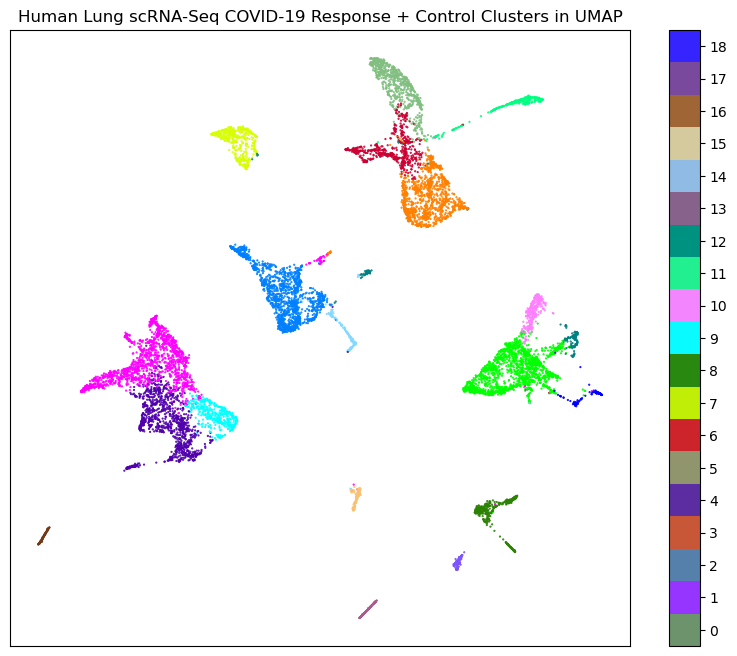

In [14]:
fig, ax = plt.subplots(1, figsize = (10,8))
colormap = np.asarray(distinctipy.get_colors(len(np.unique(labels))))
plt.scatter(*counts_umap.T, s = 0.3, c = colormap[labels])
plt.setp(ax, xticks=[], yticks=[])
cmap = mcolors.LinearSegmentedColormap.from_list("cluster_colormap", colormap)
cmappable = ScalarMappable(norm=None, cmap=cmap)
cbar = plt.colorbar(cmappable, values = np.arange(len(np.unique(labels))))
cbar.set_ticks(np.arange(len(np.unique(labels))))
cbar.set_ticklabels(np.unique(labels))
plt.title("Human Lung scRNA-Seq COVID-19 Response + Control Clusters in UMAP") 
plt.show()

## 5.) Load in the lung metadata, view annotated cell types in UMAP

NOTE: In a typical single cell RNA-seq analysis, the different clusters represent cell types and hence a downstream workflow is conducted to annotate those clusters with cell type names.  Usually this process involves identifying the marker genes of the cluster (shown in the VEME_NS-Forest.ipynb notebook) and then the cell type names can be assigned to the clusters based on prior knowledge regarding cell type marker genes.  Annotating novel cell types with novel marker genes usually requires expert curators.

Here, the cell types have already been pre-annotated along with the publication of this work.  These annotation data are in a metadata file for which we will load and use to visualize cell types in the UMAP space.

In [25]:
metadata = pd.read_csv("GSE171524_lung_metaData.txt.gz", sep = '\t', compression = "gzip")
metadata = metadata.iloc[1:] # Remove first row, irrelevant
metadata = metadata[(metadata["NAME"].isin(counts.index))]

# Appropriately sort the metadata to match order of cell name IDs in the counts matrix
metadata = metadata.set_index("NAME")
metadata = metadata.reindex(index = counts.index)
metadata = metadata.reset_index()

print(metadata.shape)
metadata.head()

(11631, 23)


,index,biosample_id,donor_id,species,species__ontology_label,disease,disease__ontology_label,organ,organ__ontology_label,library_preparation_protocol,...,cell_type_intermediate,cell_type_fine,initial_clustering,age,sex,recorded_race,recorded_ethnicity,intubation_days,interval_death_symptoms_onset_days,pmi_h
0,TAGGTACCATCATCTT-1_26,L21cov,L21cov,NCBITaxon:9606,Homo sapiens,MONDO:0100096,COVID-19,UBERON:0002048,lung,EFO:0009922,...,Fibroblasts,Intermediate pathological FB,0,68,female,NaN,NaN,36,45,5.0
1,GTGCTTCGTGATGTAA-1_6,C56ctr,C56ctr,NCBITaxon:9606,Homo sapiens,PATO:0000461,normal,UBERON:0002048,lung,EFO:0009922,...,Macrophages,Monocyte-derived macrophages,7,75,male,White,not_hispanic,NaN,NaN,NaN
2,AAGCGAGTCCCGAGGT-1_26,L21cov,L21cov,NCBITaxon:9606,Homo sapiens,MONDO:0100096,COVID-19,UBERON:0002048,lung,EFO:0009922,...,Macrophages,Alveolar macrophages,10,68,female,NaN,NaN,36,45,5.0
3,CGGGACTCATCATGAC-1_2,C52ctr,C52ctr,NCBITaxon:9606,Homo sapiens,PATO:0000461,normal,UBERON:0002048,lung,EFO:0009922,...,AT1,AT1,5,69,female,White,not_hispanic,NaN,NaN,NaN
4,GTTGTAGCAGCTGCCA-1_3,C53ctr,C53ctr,NCBITaxon:9606,Homo sapiens,PATO:0000461,normal,UBERON:0002048,lung,EFO:0009922,...,AT1,AT1,2,79,male,White,NaN,NaN,NaN,NaN


In [26]:
# Get the cell annotations

disease_status = list(metadata['disease__ontology_label'])
cell_type_main = list(metadata['cell_type_main'])
cell_type_intermediate = list(metadata['cell_type_intermediate'])

### a. View disease status in the UMAP

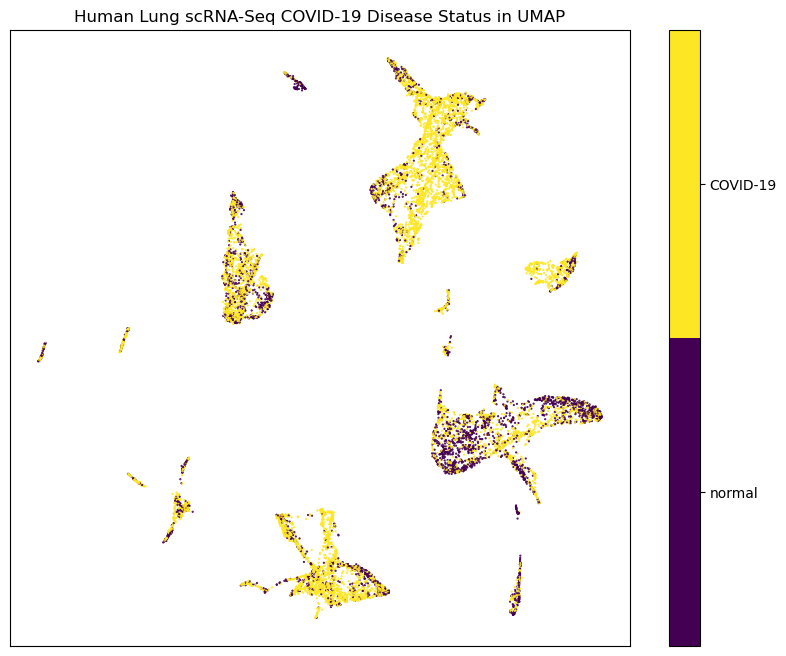

In [27]:
fig, ax = plt.subplots(1, figsize = (10,8))
cdict = {"normal": 0, "COVID-19": 1}
disease_labels = [cdict[i] for i in disease_status]
plt.scatter(*counts_umap.T, s = 0.3, c = disease_labels)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries = np.arange(3)-0.5)
cbar.set_ticks(np.arange(len(np.unique(disease_labels))))
cbar.set_ticklabels(cdict.keys())
plt.title("Human Lung scRNA-Seq COVID-19 Disease Status in UMAP")
plt.show()

### b. View the main cell types in the UMAP

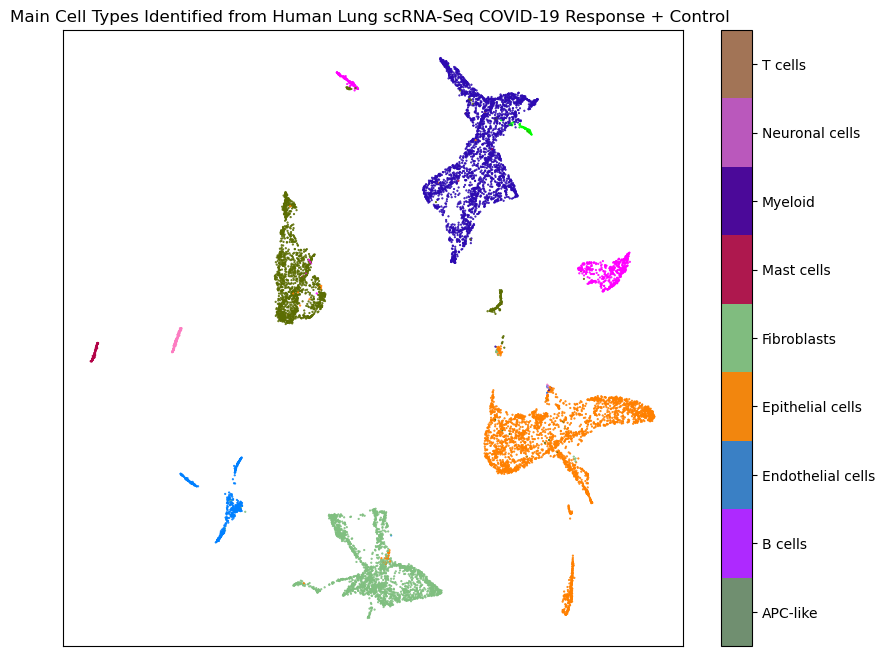

In [28]:
fig, ax = plt.subplots(1, figsize = (10,8))
cdict = {}
i = 0
for cell in np.unique(cell_type_main):
    cdict[cell] = i
    i += 1
cell_labels = [cdict[i] for i in cell_type_main]
colormap = np.asarray(distinctipy.get_colors(len(np.unique(cell_labels))))
plt.scatter(*counts_umap.T, s = 0.3, c = colormap[cell_labels])
plt.setp(ax, xticks=[], yticks=[])
cmap = mcolors.LinearSegmentedColormap.from_list("cell_main_colormap", colormap)
cmappable = ScalarMappable(norm=None, cmap=cmap)
cbar = plt.colorbar(cmappable, values=np.arange(len(cdict)))
cbar.set_ticks(np.arange(len(cdict)))
cbar.set_ticklabels(cdict.keys())
plt.title("Main Cell Types Identified from Human Lung scRNA-Seq COVID-19 Response + Control ") 
plt.show()

### c. View the intermediate cell types in the UMAP

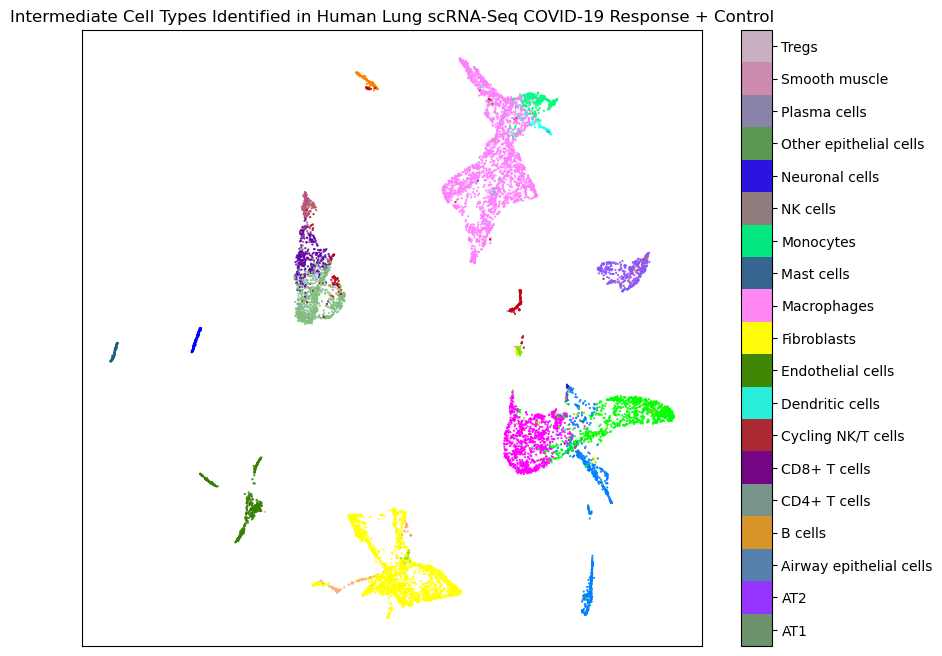

In [29]:
fig, ax = plt.subplots(1, figsize = (10,8))
cdict = {}
i = 0
for cell in np.unique(cell_type_intermediate):
    cdict[cell] = i
    i += 1
cell_labels = [cdict[i] for i in cell_type_intermediate]
colormap = np.asarray(distinctipy.get_colors(len(np.unique(cell_labels))))
plt.scatter(*counts_umap.T, s = 0.3, c = colormap[cell_labels])
plt.setp(ax, xticks=[], yticks=[])
cmap = mcolors.LinearSegmentedColormap.from_list("cell_intermediate_colormap", colormap)
cmappable = ScalarMappable(norm=None, cmap=cmap)
cbar = plt.colorbar(cmappable, values=np.arange(len(cdict)))
cbar.set_ticks(np.arange(len(cdict)))
cbar.set_ticklabels(cdict.keys())
plt.title("Intermediate Cell Types Identified in Human Lung scRNA-Seq COVID-19 Response + Control") 
plt.show()

### d. Exercise: Visualize the fine cell types in the UMAP

In [30]:
# Code for visualizing fine cell type in UMAP here:


cell_type_fine = list(metadata['cell_type_fine'])
# Insert the rest ...